In [1]:
import torch
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

---
## Dataset and Transformation

In [2]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
from PIL import Image
from torch.utils.data import Dataset

class CatsDogs(Dataset):
    def __init__(self, files, transform, target=-1):
        self.files = files
        self.transform = transform
        self.target = target # training data will have target, val/test will have -1
            
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self,idx):
        img =  Image.open(self.files[idx])
        tensor = self.transform(img)
        return tensor, self.target
        

In [4]:
import os

train_folder = './data/train'

cat_files = [os.path.join(train_folder, image) for image in os.listdir(train_folder) if "cat" in image]
dog_files = [os.path.join(train_folder, image) for image in os.listdir(train_folder) if "dog" in image]

In [5]:
import random

random.seed(2020)

VAL_SIZE = 0.2

val_cat_files = random.sample(cat_files,int(len(cat_files)*VAL_SIZE))
val_dog_files = random.sample(dog_files,int(len(dog_files)*VAL_SIZE))

train_cat_files = [c for c in cat_files if c not in val_cat_files ]
train_dog_files = [d for d in dog_files if d not in val_dog_files ]

In [6]:
from torch.utils.data import ConcatDataset, DataLoader

BATCH_SIZE = 50
NUM_WORKERS = 2

train_dataset = ConcatDataset([CatsDogs(train_cat_files,train_transform,0), CatsDogs(train_dog_files,train_transform,1)])
val_dataset = ConcatDataset([CatsDogs(val_cat_files,val_transform,0), CatsDogs(val_dog_files,val_transform,1)])

train_dataloader = DataLoader(train_dataset,batch_size=50,shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_dataset,batch_size=50,shuffle=False,num_workers=2)

### Define Model

A convolutional layer model with 4 convolutional layers

>nn.Conv2d(input_channel, output_channel, kernel_size, padding) <br>
>nn.MaxPool2d(kernel_size, stride)

> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

W = 224x224 <br>
F = 3x3<br>
S = 1<br>
P = 1<br>

output_size = (224-3+2)/1 + 1 =224

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
                                                # 224x224x3
        self.conv1 = nn.Conv2d(3,16,3,padding=1) # 112x112x16
        self.conv2 = nn.Conv2d(16,32,3,padding=1) # 56x56x32
        self.conv3 = nn.Conv2d(32,64,3,padding=1) # 28x28x64       
        self.conv4 = nn.Conv2d(64,128,3,padding=1) # 14x14x128
        self.conv5 = nn.Conv2d(128,256,3,padding=1) # 7x7x256
        
        self.pooling = nn.MaxPool2d(2,2)
        
        self.dropout = nn.Dropout(0.2) 
        self.fc1 = nn.Linear(7*7*256,500)
        self.fc2 = nn.Linear(500,1)
        
    def forward(self,x):
        out = self.pooling(F.relu(self.conv1(x)))
        out = self.pooling(F.relu(self.conv2(out)))
        out = self.pooling(F.relu(self.conv3(out)))        
        out = self.pooling(F.relu(self.conv4(out)))
        out = self.pooling(F.relu(self.conv5(out)))

        out = out.view(-1,7*7*256)
        
        out = self.dropout(out)
        out = F.relu(self.fc1(out))
        
        out = self.dropout(out)
        out = self.fc2(out) # output class score
        
        return out

### Set up training loop

In [8]:
def load_checkpoint():
    pass

In [9]:
import matplotlib.pyplot as plt 
import pandas as pd

def visualize_losses(train_losses, val_losses):
    errors = pd.DataFrame() 
    epochs = list(range(1,len(train_losses)+1))
    errors['epoch'] = epochs
    errors['train'] = train_losses
    errors['validation'] = val_losses
    
    errors = errors.set_index(errors.epoch,drop=True)
    errors.drop('epoch',axis=1,inplace=True)
    
    errors.plot()
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
    plt.gcf().set_size_inches(50, 10)
    try:
        plt.savefig('loss_plot.png')# ,dpi=200
    except:
        pass
    plt.show()
    

In [10]:
import time,copy

def train_model(n_epochs, model, criterion, optimizer, train_dataloader, val_dataloader, min_valid_loss=np.Inf):
    
    # load check points
      
    #######################
    # Initialize Training #
    #######################   
#     min_valid_loss = np.Inf
    cumulative_training_time = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    train_losses = []
    val_losses = []
    
    for i in range(n_epochs):
    
    ########################
    # Initialize the epoch #
    ########################    
        start_time = time.time()
        train_loss = val_loss = 0.

        ###################
        # train the model #
        ###################
        model.train()
        for idx, (img, target) in enumerate(train_dataloader):
            img, target = img.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(img)

            target = target.unsqueeze(-1).to(torch.float32)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * img.size(0)

        ######################
        # Validate the model #
        ######################
        model.eval()
        for idx, (img, target) in enumerate(val_dataloader):
            img, target = img.to(device), target.to(device)

            with torch.no_grad():
                output = model(img)
                target = target.unsqueeze(-1).to(torch.float32)
                loss = criterion(output,target)
                val_loss += loss.item() * img.size(0)

        ##################
        # Summarize stats #
        ##################
        # average losses
        train_loss = train_loss / len(train_dataloader.dataset)
        val_loss = val_loss / len(val_dataloader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        cumulative_training_time += (time.time() - start_time)/60       
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            i+1, train_loss, val_loss))
        print("Total training time lapsed: {:.2f} min".format(cumulative_training_time))
        
        # save the best model
        if val_loss < min_valid_loss:
            best_model_wts = copy.deepcopy(model.state_dict())
            min_valid_loss = val_loss
            print("Best model found...")
            
        print()
    
    # visualize loss graph
    visualize_losses(train_losses, val_losses)    
    return best_model_wts, model


### Train network

In [11]:
import torch.optim as optim

net = Net()
net.to(device)

net.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [12]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adagrad(net.parameters(),lr=0.001)

Epoch: 1 	Training Loss: 0.391753 	Validation Loss: 0.328671
Total training time lapsed: 1.58 min

Epoch: 2 	Training Loss: 0.262187 	Validation Loss: 0.257585
Total training time lapsed: 2.86 min

Epoch: 3 	Training Loss: 0.237935 	Validation Loss: 0.242293
Total training time lapsed: 4.04 min

Epoch: 4 	Training Loss: 0.230346 	Validation Loss: 0.236884
Total training time lapsed: 5.24 min

Epoch: 5 	Training Loss: 0.222262 	Validation Loss: 0.243948
Total training time lapsed: 6.39 min

Epoch: 6 	Training Loss: 0.221024 	Validation Loss: 0.258459
Total training time lapsed: 7.55 min

Epoch: 7 	Training Loss: 0.214119 	Validation Loss: 0.228539
Total training time lapsed: 8.74 min

Epoch: 8 	Training Loss: 0.211632 	Validation Loss: 0.235306
Total training time lapsed: 9.91 min

Epoch: 9 	Training Loss: 0.210174 	Validation Loss: 0.223191
Total training time lapsed: 11.08 min

Epoch: 10 	Training Loss: 0.206310 	Validation Loss: 0.243800
Total training time lapsed: 12.24 min

Epoch: 

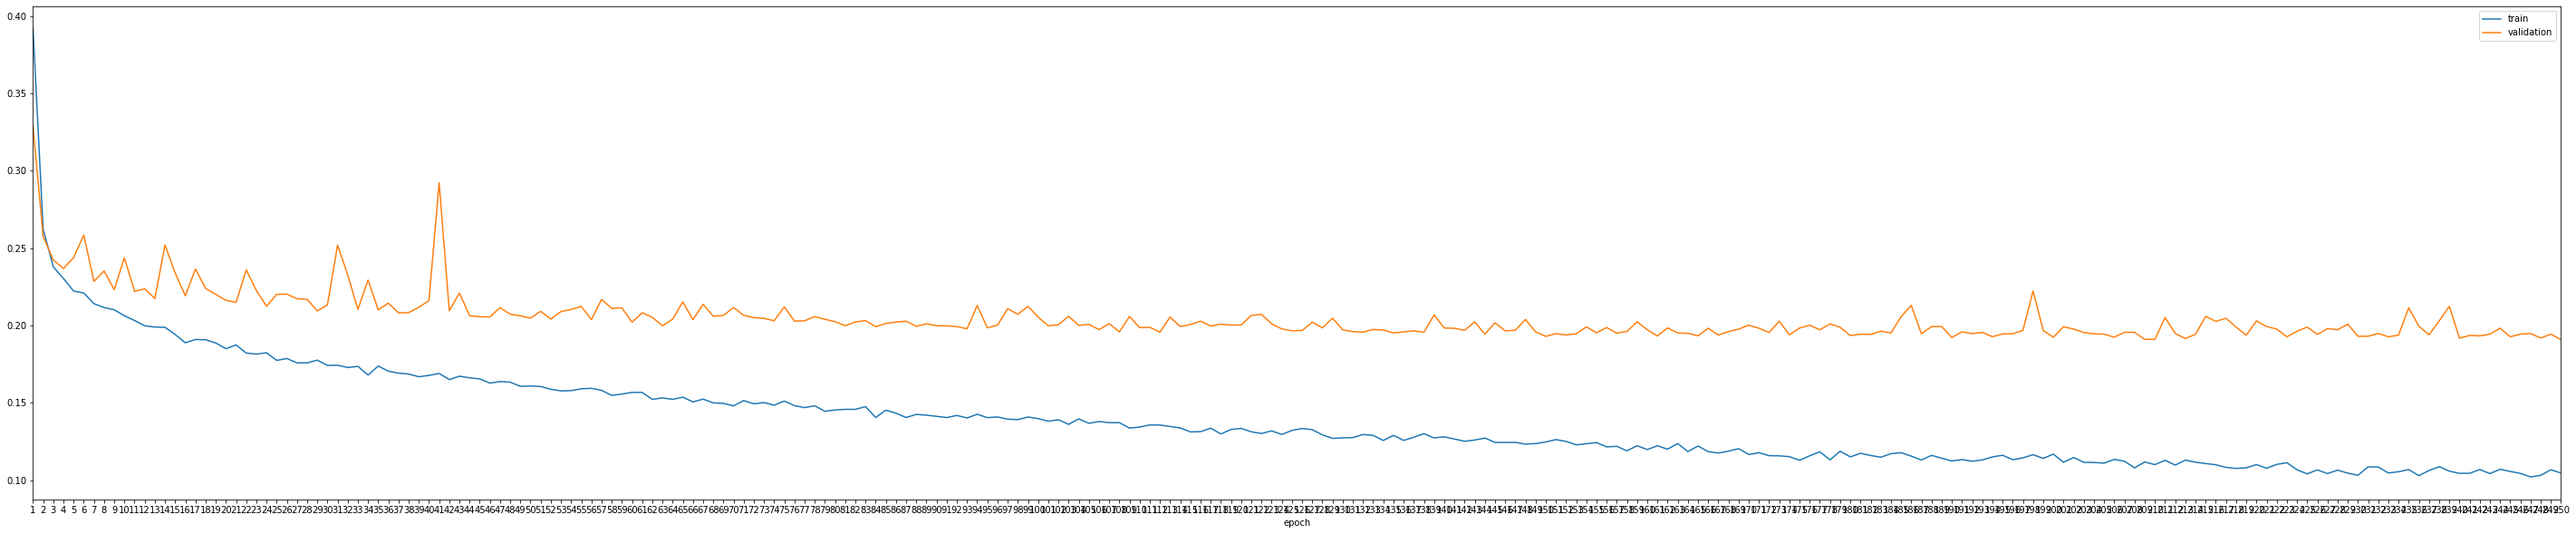

In [13]:
epoch_num = 250

best_model_wts, model = \
    train_model(epoch_num,net,criterion,optimizer, train_dataloader, val_dataloader,min_valid_loss=0.220820)

# Epoch: 100 	Training Loss: 0.514131 	Validation Loss: 0.500414
# Epoch: 97 	Training Loss: 0.462970 	Validation Loss: 0.450328
# Epoch: 98 	Training Loss: 0.428562 	Validation Loss: 0.423299

# Epoch: 241 	Training Loss: 0.195392 	Validation Loss: 0.220820
# Epoch: 250 	Training Loss: 0.104639 	Validation Loss: 0.190923

In [14]:
torch.save(best_model_wts, './best_model.pth')

In [17]:
log = '''
Epoch: 1 	Training Loss: 0.383154 	Validation Loss: 0.383865
Total training time lapsed: 1.79 min

Epoch: 2 	Training Loss: 0.382358 	Validation Loss: 0.382647
Total training time lapsed: 3.30 min

Epoch: 3 	Training Loss: 0.380815 	Validation Loss: 0.380657
Total training time lapsed: 4.70 min
Best model found...

Epoch: 4 	Training Loss: 0.381081 	Validation Loss: 0.380752
Total training time lapsed: 6.17 min

Epoch: 5 	Training Loss: 0.381590 	Validation Loss: 0.381639
Total training time lapsed: 7.57 min

Epoch: 6 	Training Loss: 0.380041 	Validation Loss: 0.381495
Total training time lapsed: 9.00 min

Epoch: 7 	Training Loss: 0.379016 	Validation Loss: 0.387886
Total training time lapsed: 10.41 min

Epoch: 8 	Training Loss: 0.379711 	Validation Loss: 0.380181
Total training time lapsed: 11.84 min
Best model found...

Epoch: 9 	Training Loss: 0.379883 	Validation Loss: 0.381218
Total training time lapsed: 13.28 min

Epoch: 10 	Training Loss: 0.380407 	Validation Loss: 0.382089
Total training time lapsed: 14.68 min

Epoch: 11 	Training Loss: 0.378938 	Validation Loss: 0.383566
Total training time lapsed: 16.12 min

Epoch: 12 	Training Loss: 0.381631 	Validation Loss: 0.382197
Total training time lapsed: 17.54 min

Epoch: 13 	Training Loss: 0.377429 	Validation Loss: 0.380504
Total training time lapsed: 18.98 min

Epoch: 14 	Training Loss: 0.380275 	Validation Loss: 0.381461
Total training time lapsed: 20.43 min

Epoch: 15 	Training Loss: 0.381064 	Validation Loss: 0.390631
Total training time lapsed: 21.85 min

Epoch: 16 	Training Loss: 0.378058 	Validation Loss: 0.379703
Total training time lapsed: 23.30 min
Best model found...

Epoch: 17 	Training Loss: 0.378635 	Validation Loss: 0.380689
Total training time lapsed: 24.76 min

Epoch: 18 	Training Loss: 0.377526 	Validation Loss: 0.379135
Total training time lapsed: 26.20 min
Best model found...

Epoch: 19 	Training Loss: 0.377606 	Validation Loss: 0.380823
Total training time lapsed: 27.61 min

Epoch: 20 	Training Loss: 0.377620 	Validation Loss: 0.379933
Total training time lapsed: 29.07 min

Epoch: 21 	Training Loss: 0.377800 	Validation Loss: 0.381961
Total training time lapsed: 30.47 min

Epoch: 22 	Training Loss: 0.378963 	Validation Loss: 0.379083
Total training time lapsed: 32.04 min
Best model found...

Epoch: 23 	Training Loss: 0.377555 	Validation Loss: 0.384256
Total training time lapsed: 33.49 min

Epoch: 24 	Training Loss: 0.379759 	Validation Loss: 0.379626
Total training time lapsed: 34.90 min

Epoch: 25 	Training Loss: 0.378487 	Validation Loss: 0.381155
Total training time lapsed: 36.31 min

Epoch: 26 	Training Loss: 0.376902 	Validation Loss: 0.379305
Total training time lapsed: 37.78 min

Epoch: 27 	Training Loss: 0.377072 	Validation Loss: 0.384885
Total training time lapsed: 39.20 min

Epoch: 28 	Training Loss: 0.375613 	Validation Loss: 0.379016
Total training time lapsed: 40.68 min
Best model found...

Epoch: 29 	Training Loss: 0.376124 	Validation Loss: 0.378003
Total training time lapsed: 42.08 min
Best model found...

Epoch: 30 	Training Loss: 0.376138 	Validation Loss: 0.378443
Total training time lapsed: 43.54 min

Epoch: 31 	Training Loss: 0.379563 	Validation Loss: 0.381295
Total training time lapsed: 44.92 min

Epoch: 32 	Training Loss: 0.377092 	Validation Loss: 0.379830
Total training time lapsed: 46.36 min

Epoch: 33 	Training Loss: 0.373727 	Validation Loss: 0.377529
Total training time lapsed: 47.80 min
Best model found...

Epoch: 34 	Training Loss: 0.374191 	Validation Loss: 0.377133
Total training time lapsed: 49.20 min
Best model found...

Epoch: 35 	Training Loss: 0.377653 	Validation Loss: 0.379316
Total training time lapsed: 50.66 min

Epoch: 36 	Training Loss: 0.377683 	Validation Loss: 0.381666
Total training time lapsed: 52.08 min

Epoch: 37 	Training Loss: 0.374256 	Validation Loss: 0.378041
Total training time lapsed: 53.56 min

Epoch: 38 	Training Loss: 0.373568 	Validation Loss: 0.377639
Total training time lapsed: 54.98 min

Epoch: 39 	Training Loss: 0.375558 	Validation Loss: 0.376721
Total training time lapsed: 56.43 min
Best model found...

Epoch: 40 	Training Loss: 0.374735 	Validation Loss: 0.376913
Total training time lapsed: 57.84 min

Epoch: 41 	Training Loss: 0.373561 	Validation Loss: 0.375793
Total training time lapsed: 59.29 min
Best model found...

Epoch: 42 	Training Loss: 0.374033 	Validation Loss: 0.377890
Total training time lapsed: 60.69 min

Epoch: 43 	Training Loss: 0.374584 	Validation Loss: 0.378323
Total training time lapsed: 62.12 min

Epoch: 44 	Training Loss: 0.375344 	Validation Loss: 0.377500
Total training time lapsed: 63.56 min

Epoch: 45 	Training Loss: 0.374308 	Validation Loss: 0.379642
Total training time lapsed: 64.96 min

Epoch: 46 	Training Loss: 0.371737 	Validation Loss: 0.380745
Total training time lapsed: 66.41 min

Epoch: 47 	Training Loss: 0.374309 	Validation Loss: 0.376257
Total training time lapsed: 67.81 min

Epoch: 48 	Training Loss: 0.374319 	Validation Loss: 0.375483
Total training time lapsed: 69.26 min
Best model found...

Epoch: 49 	Training Loss: 0.371752 	Validation Loss: 0.375870
Total training time lapsed: 70.79 min

Epoch: 50 	Training Loss: 0.372251 	Validation Loss: 0.378099
Total training time lapsed: 72.27 min

Epoch: 51 	Training Loss: 0.375011 	Validation Loss: 0.376453
Total training time lapsed: 73.69 min

Epoch: 52 	Training Loss: 0.371978 	Validation Loss: 0.375255
Total training time lapsed: 75.14 min
Best model found...

Epoch: 53 	Training Loss: 0.371645 	Validation Loss: 0.374469
Total training time lapsed: 76.58 min
Best model found...

Epoch: 54 	Training Loss: 0.373859 	Validation Loss: 0.376847
Total training time lapsed: 78.01 min

Epoch: 55 	Training Loss: 0.372627 	Validation Loss: 0.375397
Total training time lapsed: 79.49 min

Epoch: 56 	Training Loss: 0.371654 	Validation Loss: 0.378178
Total training time lapsed: 80.90 min

Epoch: 57 	Training Loss: 0.369186 	Validation Loss: 0.377461
Total training time lapsed: 82.36 min

Epoch: 58 	Training Loss: 0.370447 	Validation Loss: 0.375491
Total training time lapsed: 83.78 min

Epoch: 59 	Training Loss: 0.371624 	Validation Loss: 0.374986
Total training time lapsed: 85.26 min

Epoch: 60 	Training Loss: 0.371176 	Validation Loss: 0.375396
Total training time lapsed: 86.65 min

Epoch: 61 	Training Loss: 0.369658 	Validation Loss: 0.377982
Total training time lapsed: 88.11 min

Epoch: 62 	Training Loss: 0.369545 	Validation Loss: 0.374022
Total training time lapsed: 89.56 min
Best model found...

Epoch: 63 	Training Loss: 0.369784 	Validation Loss: 0.374726
Total training time lapsed: 90.98 min

Epoch: 64 	Training Loss: 0.370477 	Validation Loss: 0.375686
Total training time lapsed: 92.42 min

Epoch: 65 	Training Loss: 0.369360 	Validation Loss: 0.374710
Total training time lapsed: 93.87 min

Epoch: 66 	Training Loss: 0.370686 	Validation Loss: 0.374622
Total training time lapsed: 95.37 min

Epoch: 67 	Training Loss: 0.368801 	Validation Loss: 0.374886
Total training time lapsed: 96.77 min

Epoch: 68 	Training Loss: 0.369914 	Validation Loss: 0.374275
Total training time lapsed: 98.23 min

Epoch: 69 	Training Loss: 0.369369 	Validation Loss: 0.373475
Total training time lapsed: 99.63 min
Best model found...

Epoch: 70 	Training Loss: 0.368215 	Validation Loss: 0.374830
Total training time lapsed: 101.08 min

Epoch: 71 	Training Loss: 0.369276 	Validation Loss: 0.373022
Total training time lapsed: 102.52 min
Best model found...

Epoch: 72 	Training Loss: 0.368859 	Validation Loss: 0.373592
Total training time lapsed: 103.91 min

Epoch: 73 	Training Loss: 0.368251 	Validation Loss: 0.372834
Total training time lapsed: 105.38 min
Best model found...

Epoch: 74 	Training Loss: 0.367807 	Validation Loss: 0.374649
Total training time lapsed: 106.78 min

Epoch: 75 	Training Loss: 0.370096 	Validation Loss: 0.373144
Total training time lapsed: 108.27 min

Epoch: 76 	Training Loss: 0.366967 	Validation Loss: 0.375481
Total training time lapsed: 109.71 min

Epoch: 77 	Training Loss: 0.370172 	Validation Loss: 0.373313
Total training time lapsed: 111.17 min

Epoch: 78 	Training Loss: 0.365229 	Validation Loss: 0.372840
Total training time lapsed: 112.60 min

Epoch: 79 	Training Loss: 0.367553 	Validation Loss: 0.371625
Total training time lapsed: 114.00 min
Best model found...

Epoch: 80 	Training Loss: 0.367956 	Validation Loss: 0.373373
Total training time lapsed: 115.47 min

Epoch: 81 	Training Loss: 0.367127 	Validation Loss: 0.375136
Total training time lapsed: 116.88 min

Epoch: 82 	Training Loss: 0.366460 	Validation Loss: 0.371644
Total training time lapsed: 118.34 min

Epoch: 83 	Training Loss: 0.369021 	Validation Loss: 0.377796
Total training time lapsed: 119.76 min

Epoch: 84 	Training Loss: 0.369053 	Validation Loss: 0.372351
Total training time lapsed: 121.18 min

Epoch: 85 	Training Loss: 0.366926 	Validation Loss: 0.373683
Total training time lapsed: 122.61 min

Epoch: 86 	Training Loss: 0.367987 	Validation Loss: 0.372387
Total training time lapsed: 124.03 min

Epoch: 87 	Training Loss: 0.366589 	Validation Loss: 0.372923
Total training time lapsed: 125.51 min

Epoch: 88 	Training Loss: 0.368852 	Validation Loss: 0.371088
Total training time lapsed: 126.92 min
Best model found...

Epoch: 89 	Training Loss: 0.365621 	Validation Loss: 0.371578
Total training time lapsed: 128.43 min

Epoch: 90 	Training Loss: 0.366991 	Validation Loss: 0.373498
Total training time lapsed: 129.87 min

Epoch: 91 	Training Loss: 0.367120 	Validation Loss: 0.372565
Total training time lapsed: 131.34 min

Epoch: 92 	Training Loss: 0.365797 	Validation Loss: 0.371669
Total training time lapsed: 132.76 min

Epoch: 93 	Training Loss: 0.365047 	Validation Loss: 0.379160
Total training time lapsed: 134.20 min

Epoch: 94 	Training Loss: 0.365152 	Validation Loss: 0.373340
Total training time lapsed: 135.63 min

Epoch: 95 	Training Loss: 0.366077 	Validation Loss: 0.373712
Total training time lapsed: 137.08 min

Epoch: 96 	Training Loss: 0.362354 	Validation Loss: 0.371631
Total training time lapsed: 138.54 min

Epoch: 97 	Training Loss: 0.366256 	Validation Loss: 0.370974
Total training time lapsed: 140.00 min
Best model found...

Epoch: 98 	Training Loss: 0.369046 	Validation Loss: 0.369931
Total training time lapsed: 141.48 min
Best model found...

Epoch: 99 	Training Loss: 0.367149 	Validation Loss: 0.369632
Total training time lapsed: 142.89 min
Best model found...

Epoch: 100 	Training Loss: 0.362691 	Validation Loss: 0.370650
Total training time lapsed: 144.36 min
'''
train_losses = []
val_losses = []
for l in log.split('\n'):
    if 'Epoch' in l:
        idx = l.index('Loss: ')+6
        train_losses.append(float(l[idx:idx+9]))
        val_losses.append(float(l[-8:]))